In [43]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
from jobs.theory_lapse.scripts.lapse_fitting import processed_dir, processed_file_name, exp_name, quant_type

n_exp = len(exp_name)
quant = int(''.join(filter(str.isdigit, quant_type)))

In [44]:
# Load in data
ds = [xr.open_dataset(os.path.join(processed_dir[i], processed_file_name)) for i in range(n_exp)]
co2_vals = [get_co2_multiplier(i) for i in exp_name]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))
ds['rh_REFHT'] = ds['QREFHT'] / sphum_sat(ds.TREFHT, ds.PREFHT)

In [6]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
land_frac_thresh = 0.1
lsm = (land_frac > land_frac_thresh)

In [7]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30]),
                             bottom_labels=True, fontsize=None):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    if fontsize is not None:
        gl.xlabel_style = {'size': fontsize}
        gl.ylabel_style = {'size': fontsize}
    if not bottom_labels:
        gl.bottom_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [8]:
def get_var_av(var, n_lat_av=30, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take mean over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av

## Temperature anomaly and change
Figure trying to explain, why hottest days in some regions more in current climate and change with warming differently

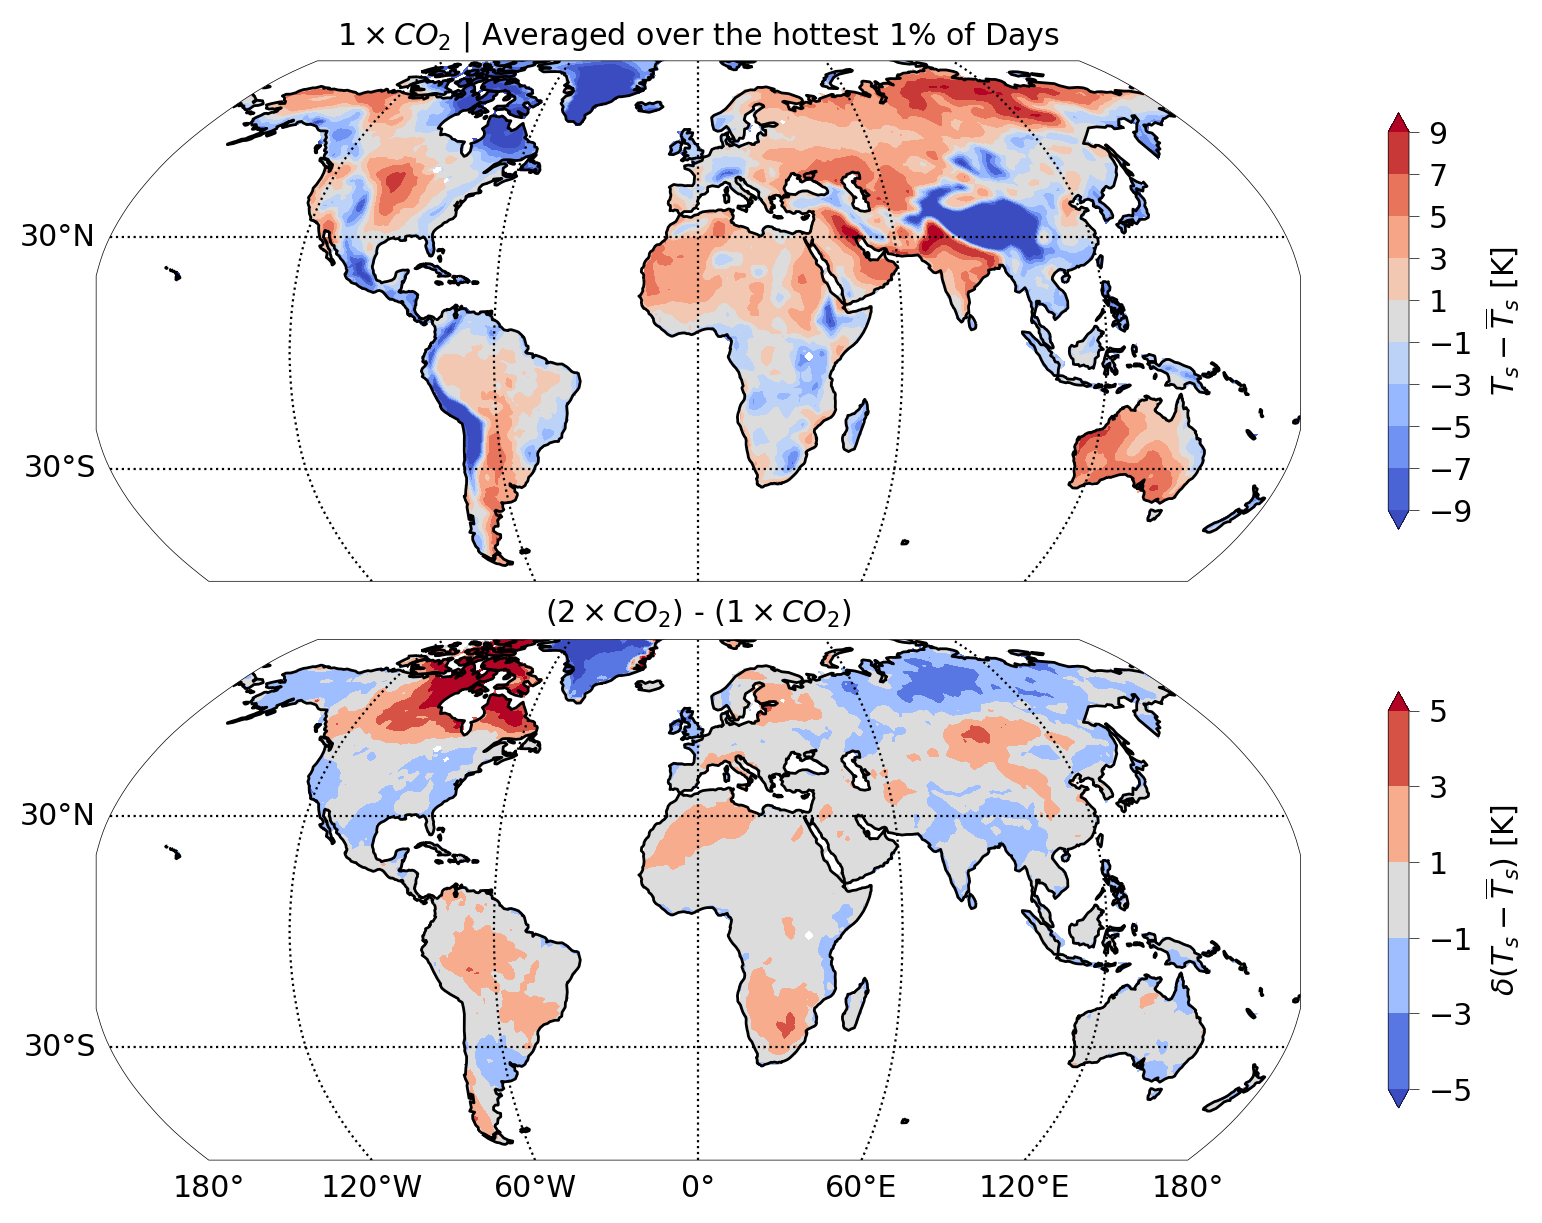

In [17]:
lat_min = -60
lat_max = 80
fig = plt.figure(constrained_layout=True, figsize=(10., 6))
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})

var = (ds.TREFHT.mean(dim='sample') - get_var_av(ds.TREFHT, mask=lsm, av_dim=['sample', 'lon'])).where(lsm)
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=False, fontsize=10.84)
im = plot_contour_projection(ax[0], var.isel(co2=0), cmap='coolwarm', levels=np.arange(-9, 10, 2))
plt.colorbar(im, ax=ax[0], label='$T_s - \overline{T}_s$ [K]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | Averaged over the hottest {100 - quant}% of Days")

initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
im = plot_contour_projection(ax[1], var.isel(co2=1) - var.isel(co2=0), cmap='coolwarm', levels=np.arange(-5, 6, 2))
plt.colorbar(im, ax=ax[1], label='$\delta (T_s - \overline{T}_s)$ [K]', shrink=0.8)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
plt.show()
# isca_tools.savefig(fig)

In [8]:
# ds_use = ds.sel(lat=3, lon=15, method='nearest')         # Congo
# ds_use = ds.sel(lat=-14.6, lon=320, method='nearest')  # Amazon 2
# ds_use = ds.sel(lat=35, lon=100, method='nearest')       # Tibet
# ds_use = ds.sel(lat=55, lon=290, method='nearest')       # Large inversion
# ds_use = ds.sel(lat=-85, lon=100, method='nearest')     # Antarctica
# ds_use = ds.sel(lat=75, lon=320, method='nearest')       # Greenland
ds_use = ds.sel(lat=25, lon=50, method='nearest')  # Pursian gulf
# ds_use = ds.sel(lat=28, lon=50, method='nearest')  # Pursian gulf coastline
# ds_use = ds.sel(lat=18, lon=0, method='nearest')  # Sahara
# ds_use = ds.sel(lat=30, lon=180, method='nearest')  # Ocean
# ds_use = ds.sel(lat=53, lon=100, method='nearest')  # Canada
ds_use = ds_use.isel(co2=0, sample=0)

# High CAPE scenario
# ds_use = ds.sel(lat=50, method='nearest').isel(sample=0)
# lon_ind = ds.CAPE.where(valid_all).sel(lat=float(ds_use.lat)).isel(sample=0).argmax()
# ds_use = ds_use.isel(lon=lon_ind)
# ds_use = ds_use.isel(co2=0)

### % of Days convective
Below I plot the number of days for which the convective fitting works well.

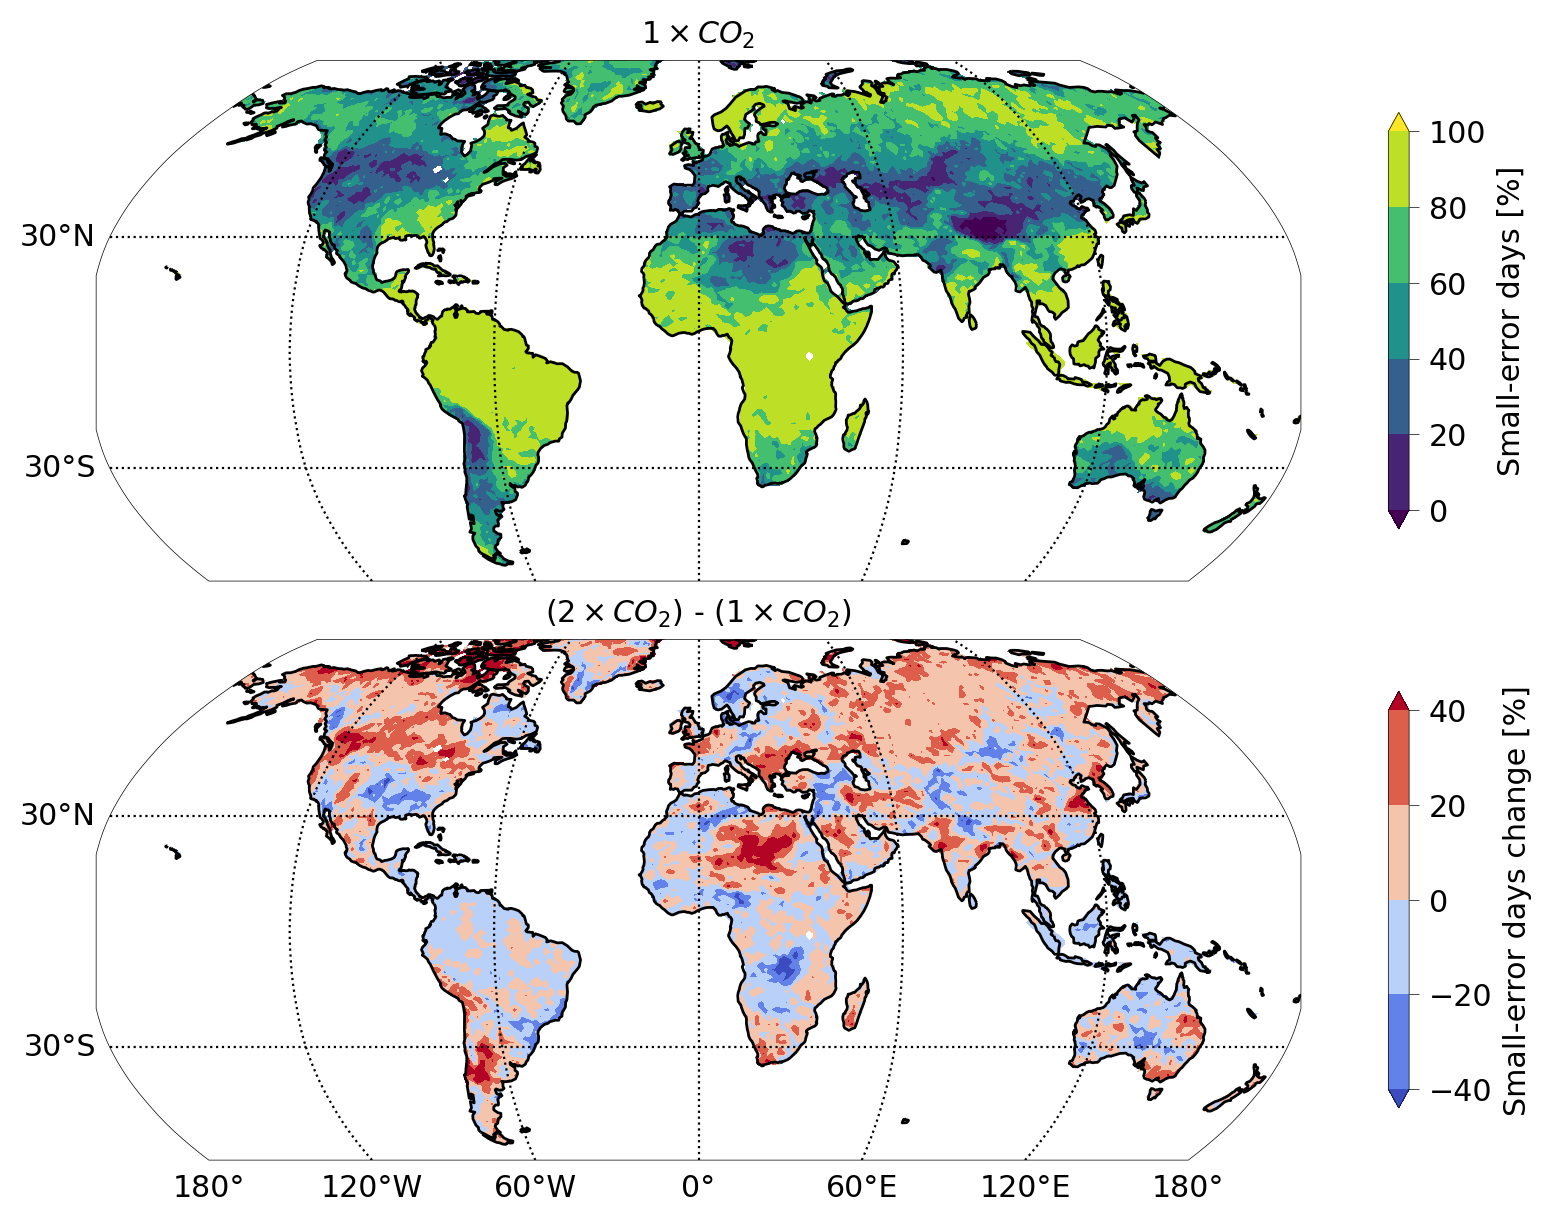

In [33]:
error_thresh = 0.25
error_thresh2 = 0.1
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)

fig = plt.figure(constrained_layout=True, figsize=(10., 6))
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})

var = (100 * mask_fit.sum(dim='sample') / ds.sample.size).where(lsm)
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=False, fontsize=10.84)
im = plot_contour_projection(ax[0], var.isel(co2=0), levels=np.arange(0, 120, 20))
plt.colorbar(im, ax=ax[0], label='Small-error days [%]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$")

initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
im = plot_contour_projection(ax[1], var.isel(co2=1) - var.isel(co2=0), cmap='coolwarm', levels=np.arange(-40, 60, 20))
plt.colorbar(im, ax=ax[1], label='Small-error days change [%]', shrink=0.8)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
plt.show()
# isca_tools.savefig(fig)

In [216]:
error_use = 100 * ds.isel(co2=0, sample=0).mod_parcel1_error.sum(dim='layer') / ds.isel(co2=0,
                                                                                        sample=0).mod_parcel1_integral.sum(
    dim='layer')
error_use2 = 100 * ds.isel(co2=0, sample=0).const1_error.sum(dim='layer') / ds.isel(co2=0,
                                                                                    sample=0).const1_integral.sum(
    dim='layer')
error_use = np.abs(error_use)
error_use2 = np.abs(error_use2)
# error_use.lon.where(lsm & (error_use > 25) & (error_use2 < 12)).sel(lat=60, method='nearest')

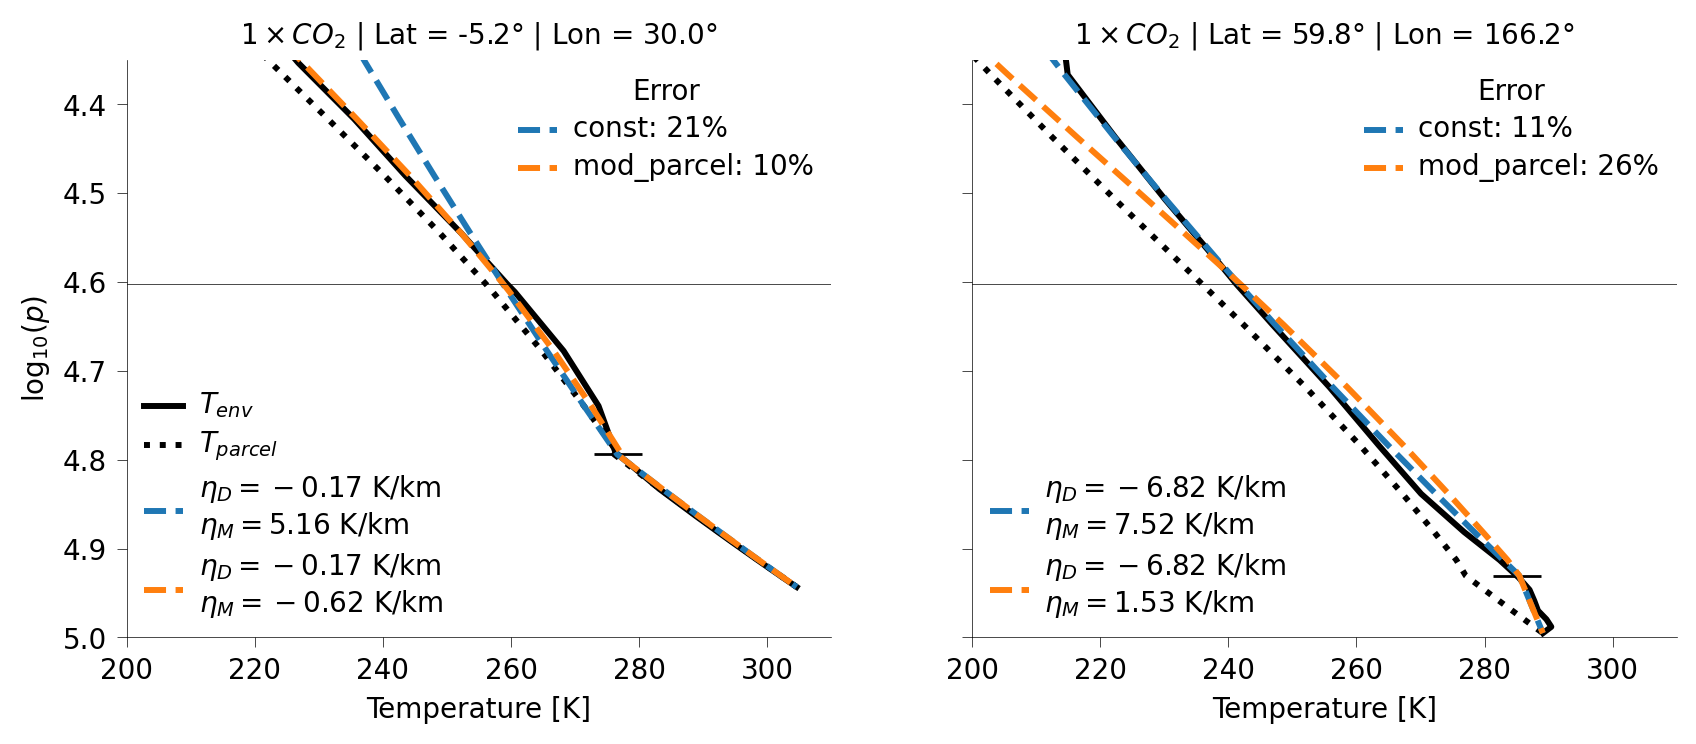

In [215]:
temp_surf_lcl_calc = 300
lat_plot = [-5, 60]
lon_plot = [30, 166]
n_plot = len(lat_plot)
show_lcl_markers = True

fig, ax = plt.subplots(1, n_plot, sharey=True, sharex=True)
fig_resize(fig, 10)
for j in range(n_plot):
    ds_plot = ds.sel(lat=lat_plot[j], lon=lon_plot[j], method='nearest').isel(sample=0, co2=0)
    ds_plot['lnb_ind'] = get_lnb_lev_ind(ds_plot.T, ds_plot.Z3, ds_plot.P)
    p_thresh = float(ds_plot.P.isel(lev=ds_plot.lnb_ind) - 1)
    p_thresh = 0

    ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, temp_surf_lcl_calc) * ds_plot.PREFHT
    ds_plot['T_lcl_env'] = get_var_at_plev(ds_plot.T, ds_plot.P, ds_plot.p_lcl)


    p_use, temp_env_use = insert_to_array(ds_plot.P.to_numpy(), ds_plot.T.to_numpy(),
                                          [float(ds_plot.p_lcl), ds_plot.p_ft],
                                          [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
    use_lev = p_use >= p_thresh
    ax[j].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k', label='$T_{env}$' if j==0 else None)

    T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                           float(ds_plot.rh_REFHT),
                                           lapse_dry, 0,
                                           method_layer2='mod_parcel')
    ax[j].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':', label='$T_{parcel}$' if j==0 else None)

    line_leg2 = []
    line_leg2_label = []
    for i, key in enumerate(['const1', 'mod_parcel1']):
        temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                  float(ds_plot[f"rh_REFHT"]),
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                  method_layer2=key.replace('1', ''))
        label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f}$ K/km\n"
                     f"$\eta_{'{M}'} = {ds_plot[f'{key}_lapse'].isel(layer=1):.2f}$ K/km")
        line, = ax[j].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                               label=label_use, linestyle='--')
        line_leg2.append(line)
        label_use = f'{key[:-1]}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        line_leg2_label.append(label_use)

    if show_lcl_markers:
        ax[j].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
    update_linewidth(fig, 1.5)
    # Legend 2 (e.g., model meaning)
    leg2 = ax[j].legend(
        handles=line_leg2,
        labels=line_leg2_label,
        loc="upper right",
        title="Error"
    )
    ax[j].add_artist(leg2)
    ax[j].legend(loc='lower left')
    ax[j].set_title(
    f"${int(ds_plot.co2)} \\times CO_2$ | Lat = {ds_plot.lat:.1f}$\degree$ | Lon = {ds_plot.lon:.1f}$\degree$",
    fontsize=8.5)


ax[0].invert_yaxis()

ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature [K]')
#
ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
ax[1].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
# ax[1].scatter(0, np.log10(p_use[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
#
# # update_linewidth(fig)

ax[0].set_ylim(5, 4.35)
ax[0].set_xlim(200, 310)
update_fontsize(fig, 7)
plt.show()
# isca_tools.savefig(fig)

### Initial analysis for spatial variation within a climate
Below I create 2 figures to allow comparison between the spatial variation of `TREFHT` with the lapse rate, LCL height and $T_{FT}$. These are the variables that influence `TREFHT` through a vertical profile decomposition.

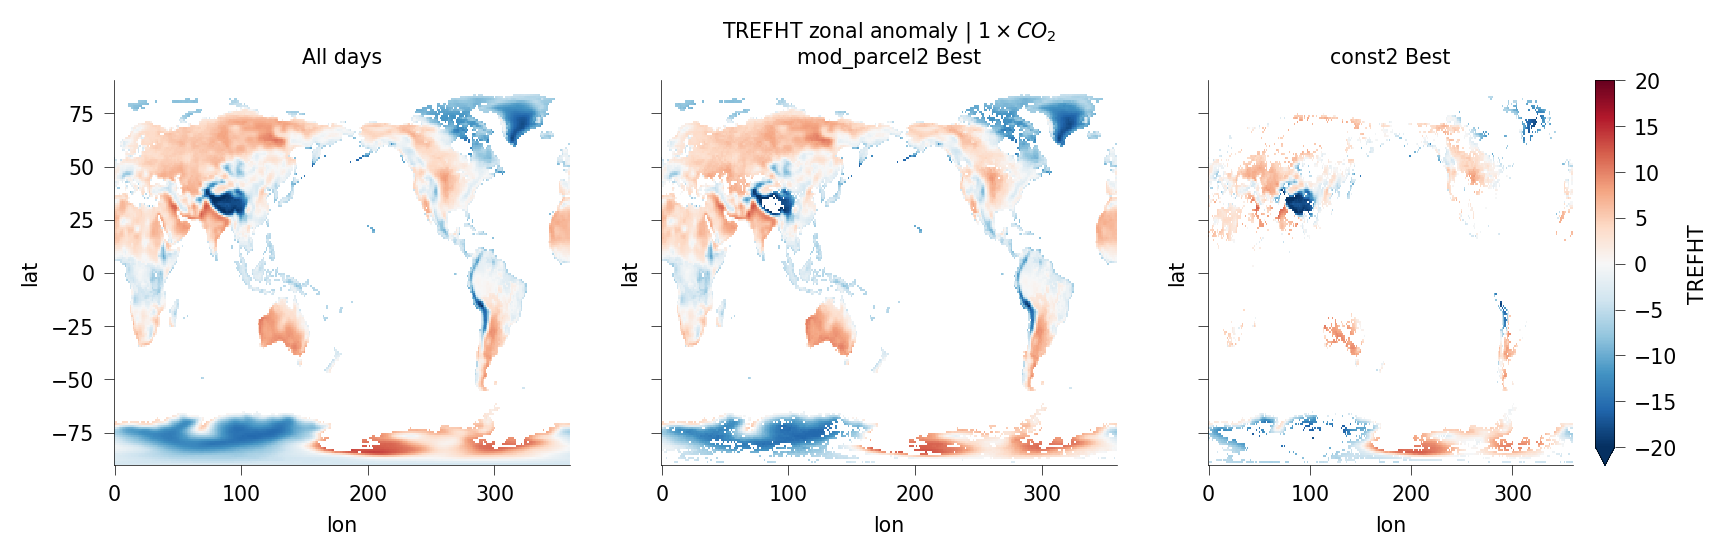

In [552]:
co2_ind = 0
n_days_plot = 5
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

(ds.TREFHT.mean(dim='sample') - get_var_av(ds.TREFHT, mask=lsm, av_dim=['sample', 'lon'])
 ).isel(co2=co2_ind).where(lsm).plot(ax=ax[0], vmax=20, add_colorbar=False)
for i, key in enumerate(['mod_parcel2', 'const2']):
    show_reg = lsm & (mask_fit[key].isel(co2=co2_ind).sum(dim='sample') > n_days_plot)
    (ds.TREFHT.where(mask_fit[key]).mean(dim='sample') - get_var_av(ds.TREFHT, mask=mask_fit[key] & lsm,
                                                                    av_dim=['sample', 'lon'])
     ).isel(co2=co2_ind).where(show_reg).plot(ax=ax[1 + i], vmax=20, add_colorbar=i == 1)
ax[0].set_title('All days')
ax[1].set_title(f'TREFHT zonal anomaly | ${int(ds.co2[co2_ind])} \\times CO_2$\nmod_parcel2 Best')
ax[2].set_title('const2 Best')
update_fontsize(fig, 8)
plt.show()

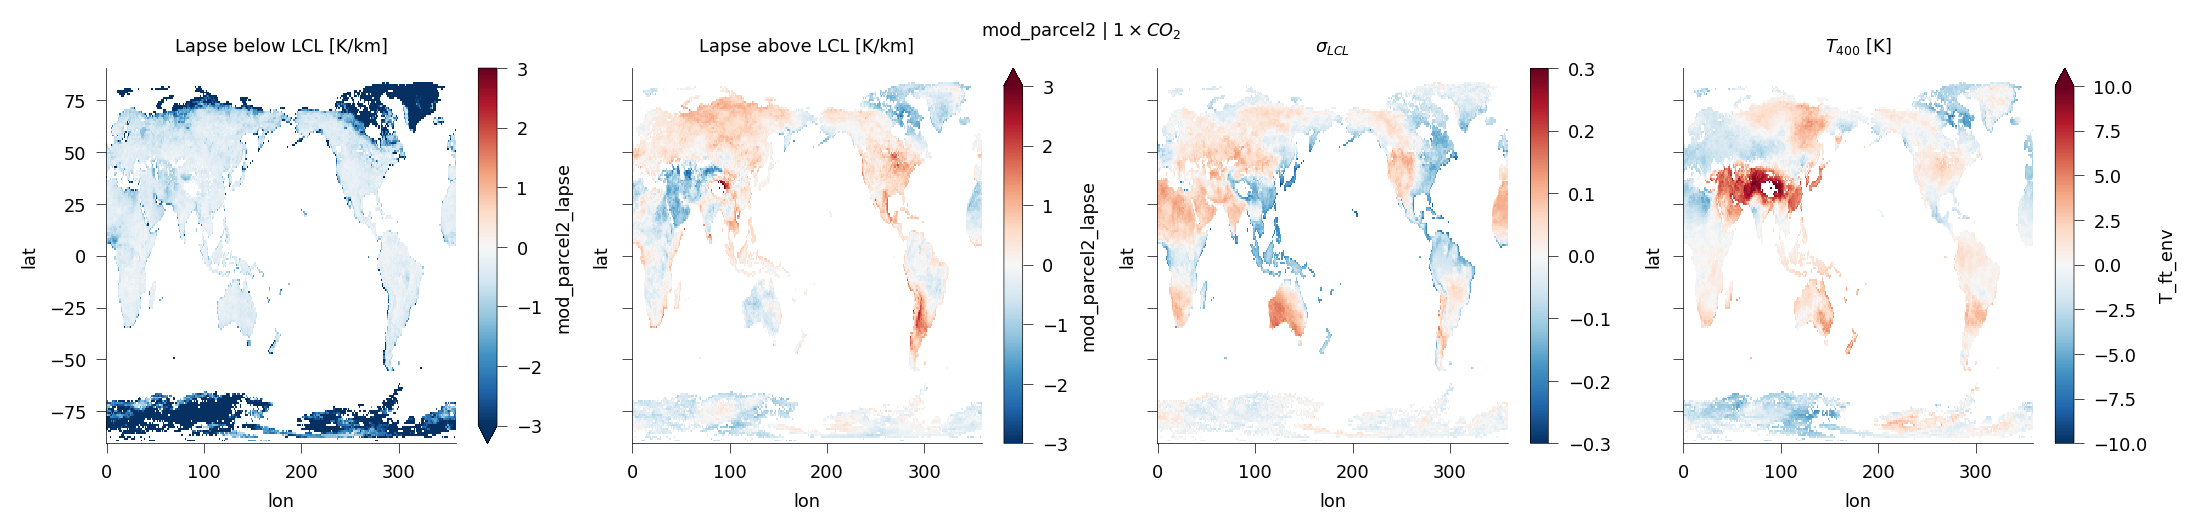

In [564]:
key = 'mod_parcel2'
co2_ind = 0
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig_resize(fig, 13)
for i in range(ds.layer.size):
    var = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).mean(dim='sample')
    if i == 0:
        # var_av = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).isel(co2=co2_ind).where(lsm).median()
        var_av = lapse_dry * 1000
    else:
        var_av = get_var_av(ds[f"{key}_lapse"].isel(layer=i), mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
    var = var - var_av
    show_reg = lsm & (mask_fit[key].isel(co2=co2_ind).sum(dim='sample') > n_days_plot)
    var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[i], vmax=3)
var = ds[f"{key}_p_lcl" if '2' in key else 'p_lcl'] / ds.PREFHT
var = -var.where(mask_fit[key]).mean(dim='sample') + get_var_av(var, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[2], vmax=0.3)

var = ds.T_ft_env
var = var.where(mask_fit[key]).mean(dim='sample') - get_var_av(var, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
var.isel(co2=co2_ind).where(show_reg).plot(ax=ax[3], vmax=10)

ax[0].set_title('Lapse below LCL [K/km]')
ax[1].set_title('Lapse above LCL [K/km]')
ax[2].set_title('$\sigma_{LCL}$')
ax[3].set_title(f'$T_{"{" + str(int(ds.p_ft / 100)) + "}"}$ [K]')
fig.suptitle(f'{key} | ${int(ds.co2[co2_ind])} \\times CO_2$')
update_fontsize(fig, 9)
plt.show()

### Initial analysis for change with warming
Below I repeat the above plots, but for the change with warming.

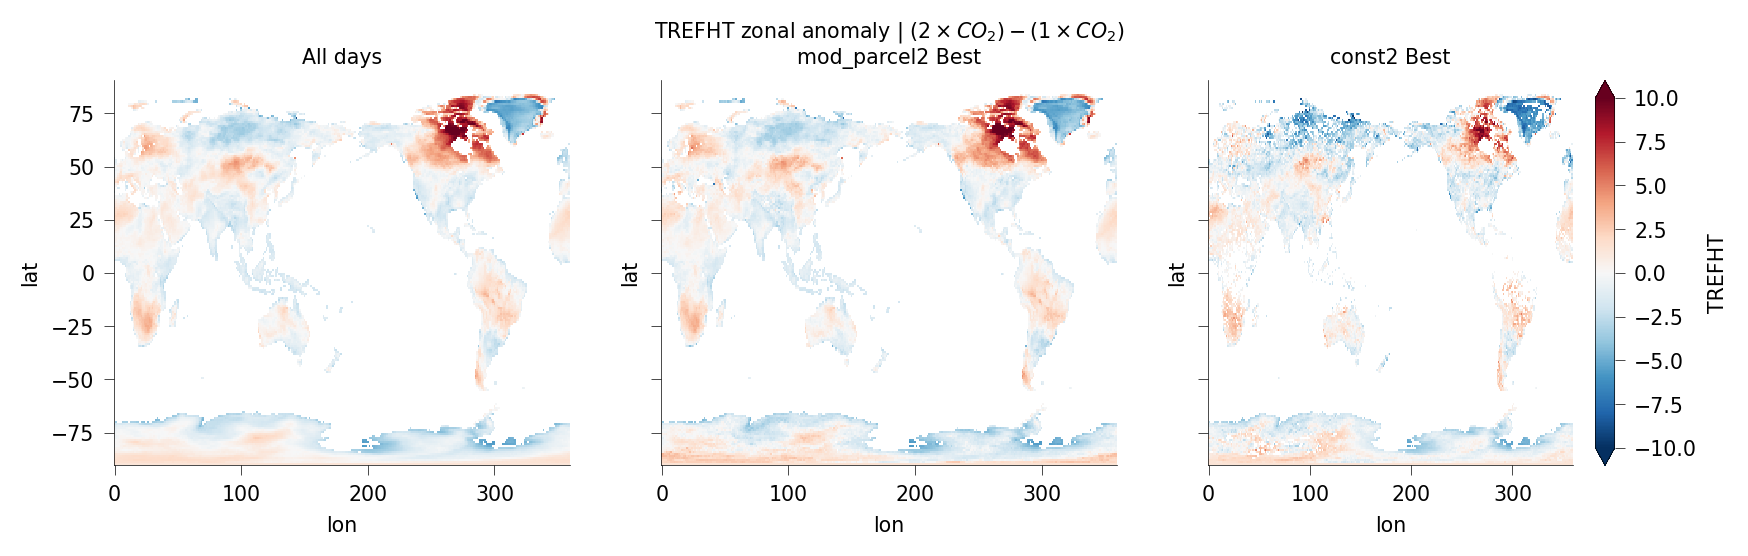

In [561]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
var = ds.TREFHT.mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
var = (var - get_var_av(var, mask=lsm))
var.where(lsm).plot(ax=ax[0], vmax=10, add_colorbar=False)

for i, key in enumerate(['mod_parcel2', 'const2']):
    var = ds.TREFHT.where(mask_fit[key]).mean(dim='sample')
    var = var.isel(co2=1) - var.isel(co2=0)
    show_reg = lsm & (mask_fit[key].isel(co2=0).sum(dim='sample') > n_days_plot) & (
            mask_fit[key].isel(co2=1).sum(dim='sample') > n_days_plot)
    (var - get_var_av(var, mask=show_reg)).where(lsm).plot(ax=ax[1 + i], vmax=10, add_colorbar=i == 1)
    # (ds.TREFHT.where(mask_fit[key]).mean(dim='sample') - get_var_av(ds.TREFHT, mask=mask_fit[key] & lsm, av_dim=['sample', 'lon'])
    #  ).isel(co2=co2_ind).where(show_reg).plot(ax=ax[1+i], vmax=20, add_colorbar=False)
ax[0].set_title('All days')
ax[1].set_title(
    f'TREFHT zonal anomaly | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$\nmod_parcel2 Best')
ax[2].set_title('const2 Best')
update_fontsize(fig, 8)
plt.show()

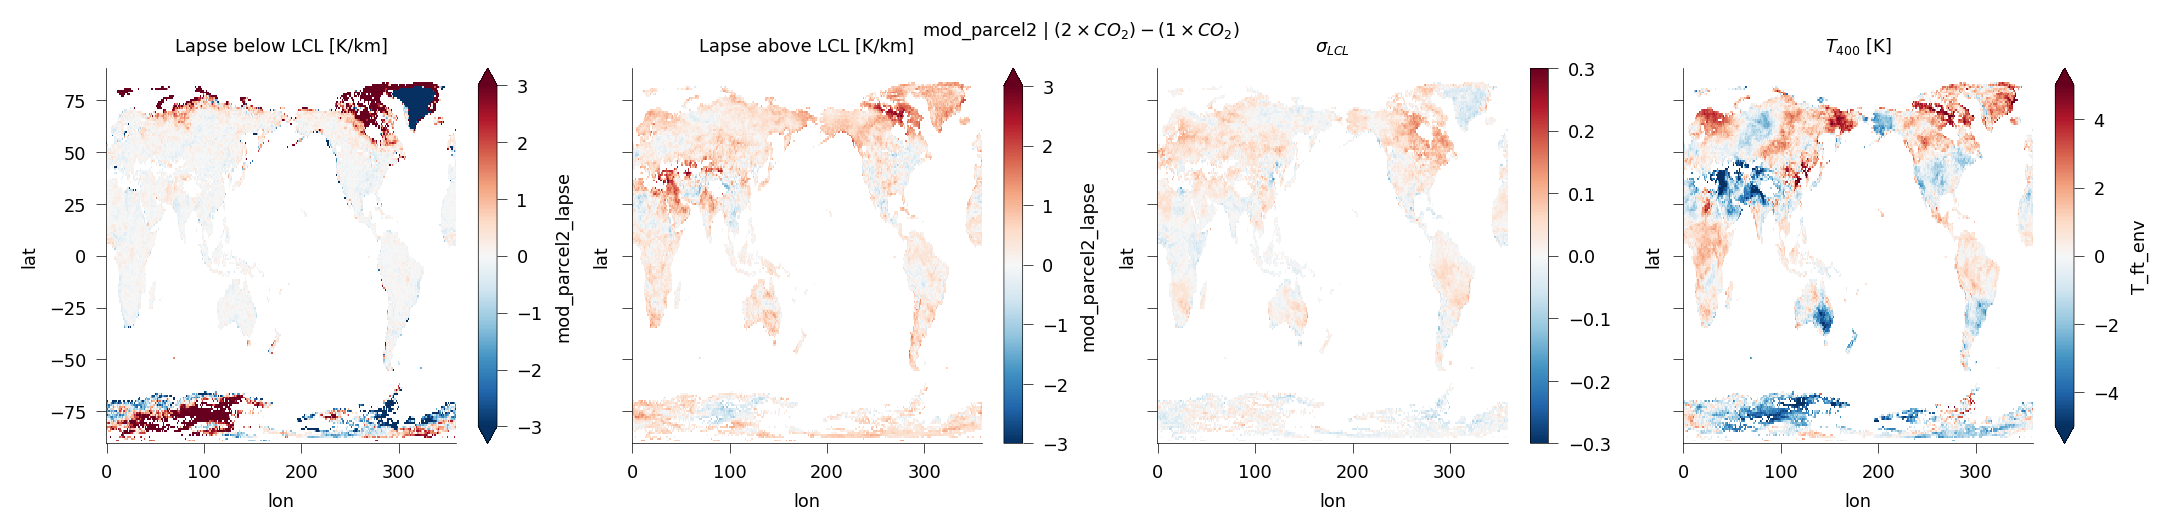

In [571]:
key = 'mod_parcel2'
show_anom = False
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig_resize(fig, 13)
show_reg = lsm & (mask_fit[key].isel(co2=0).sum(dim='sample') > n_days_plot) & (
        mask_fit[key].isel(co2=1).sum(dim='sample') > n_days_plot)
for i in range(ds.layer.size):
    var = ds[f"{key}_lapse"].isel(layer=i).where(mask_fit[key]).mean(dim='sample')
    var = var.isel(co2=1) - var.isel(co2=0)
    if show_anom and (i == 1):
        var = var - get_var_av(var, mask=show_reg)
    var.where(show_reg).plot(ax=ax[i], vmax=3)

var = ds[f"{key}_p_lcl" if '2' in key else 'p_lcl'] / ds.PREFHT
var = -var.where(mask_fit[key]).mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
if show_anom:
    var = var - get_var_av(var, mask=show_reg)
var.where(show_reg).plot(ax=ax[2], vmax=0.3)

var = ds.T_ft_env.where(mask_fit[key]).mean(dim='sample')
var = var.isel(co2=1) - var.isel(co2=0)
if show_anom:
    var = var - get_var_av(var, mask=show_reg)
else:
    var = var - var.where(lsm).median()
var.where(show_reg).plot(ax=ax[3], vmax=5)

ax[0].set_title('Lapse below LCL [K/km]')
ax[1].set_title('Lapse above LCL [K/km]')
ax[2].set_title('$\sigma_{LCL}$')
ax[3].set_title(f'$T_{"{" + str(int(ds.p_ft / 100)) + "}"}$ [K]')
fig.suptitle(f'{key} | $({int(ds.co2[1])} \\times CO_2) - ({int(ds.co2[0])} \\times CO_2)$')
update_fontsize(fig, 9)
plt.show()